In [1]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
class Node():
    """Класс вершины дерева"""

    def __init__(self, name):
        self.name = name
        self.children = []
        self.x = None
        self.y = None
        self.children_shifts = [0]
        self.shift = 0

    def add_child(self, child_node):
        """Добавление потомка вершины"""
        self.children.append(child_node)

    def set_coords(self, x, y):
        """Задает начальные координаты вершины и ее потомков"""
        middle = len(self.children) // 2
        for i in range(0, middle):
            y = self.children[i].set_coords(x + 1, y)
        self.x, self.y = x, y
        if len(self.children) != 1:
            y += 1
        for i in range(middle, len(self.children)):
            y = self.children[i].set_coords(x + 1, y)
        return y


class Tree():
    """Класс дерева"""
    def __init__(self, file_name):
        G = nx.read_graphml(file_name)
        self.root = self.build_tree(list(G.nodes()), list(G.edges())) #корень дерева
        self.contour = None
        self.size = len(list(G.nodes()))

    def build_tree(self, node_lst, edge_lst):
        """Построение дерева из списка вершин и ребер"""
        nodes = dict()
        possible_roots = set(node_lst)
        for edge in edge_lst:
            possible_roots.remove(edge[1])
            if edge[1] not in nodes:
                nodes[edge[1]] = Node(edge[1])
            if edge[0] not in nodes:
                nodes[edge[0]] = Node(edge[0])
                nodes[edge[0]].add_child(nodes[edge[1]])
            else:
                nodes[edge[0]].add_child(nodes[edge[1]])
        return nodes[possible_roots.pop()]

    def set_nodes_coords(self):
        """Задает координаты корня и его потомков"""
        self.root.set_coords(0, 0)

    def shift_contours(self):
        """Делает сдвиг координат вершин"""
        def get_subtree_contour(root):
            if len(root.children) == 0:
                return [(root.y, root.y)]
            left_contour = get_subtree_contour(root.children[0])
            for i in range(1, len(root.children)):
                right_countour = get_subtree_contour(root.children[i])
                right_countour, shift = make_shift(left_contour, right_countour)
                root.children_shifts.append(shift)
                left_contour = unite_contours(left_contour, right_countour)
            if len(left_contour) > 0:
                root.y = sum(left_contour[0]) // 2
            return [(root.y, root.y)] + left_contour

        def make_shift(left_contour, right_countour):
            min_len = min(len(left_contour), len(right_countour))
            shift = -1
            for i in range(min_len):
                possible_shift = right_countour[i][0] - left_contour[i][1] - 1
                if shift == -1:
                    shift = possible_shift
                elif possible_shift < shift:
                    shift = possible_shift
            if shift > 0:
                for i in range(len(right_countour)):
                    right_countour[i] = (right_countour[i][0] - shift,
                                        right_countour[i][1] - shift)
            return right_countour, shift

        def unite_contours(left_contour, right_countour):
            min_len = min(len(left_contour), len(right_countour))
            res = [(left_contour[i][0], right_countour[i][1]) for i in range(min_len)]
            for i in range(min_len, len(left_contour)):
                res.append(left_contour[i])
            for i in range(min_len, len(right_countour)):
                res.append(right_countour[i])
            return res

        self.contour = get_subtree_contour(self.root)

    def show(self):
        """Строит изображение графа"""
        def make_coord_lst(node, shift):
            node_coord_lst = [(node.name, node.y-shift, -node.x)]
            edges = []
            for i in range(len(node.children)):
                edges.append((node.name, node.children[i].name))
                child_coord_lst, child_edges = make_coord_lst(node.children[i], shift+node.children_shifts[i])
                node_coord_lst += child_coord_lst
                edges += child_edges
            return node_coord_lst, edges

        xticks_max = self.size
        if self.contour is not None:
            xticks_max = max(map(lambda x: x[1], self.contour))

        coord_lst, edges = make_coord_lst(self.root, 0)
        G_to_draw = nx.DiGraph()
        for i in range(len(coord_lst)):
            G_to_draw.add_node(coord_lst[i][0], pos=(coord_lst[i][1], coord_lst[i][2]))
        G_to_draw.add_edges_from(edges)

        fig, ax = plt.subplots()
        nx.draw_networkx(
            G_to_draw,
            nx.get_node_attributes(G_to_draw, 'pos'),
            with_labels=False,
            node_size=100,
            ax=ax
        )
        ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
        ax.set_xticks(range(0, xticks_max+1, 2))
        plt.grid('on')
        
        plt.show()

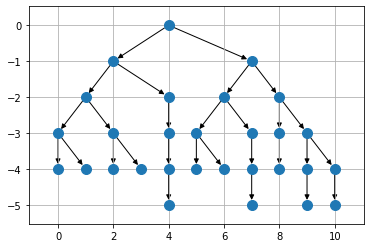

In [42]:
tree = Tree('data/binary-tree-28n.xml')
tree.set_nodes_coords()
tree.shift_contours()
tree.show()